In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from datetime import date
import cmocean.cm as cmo
from pyproj import Transformer
from scipy.interpolate import griddata
import pandas as pandas
import cartopy as cy
import string

In [2]:
# define file paths

deffp = '/home/janheuser/projects/def/release_3/release/' #observational estimates from Anheuser et al. (2023) and region mask
piofp = '/ships19/cryo/janheuser/piomas/' #piomas data
omipdir = '/ships19/cryo/janheuser/omip/steflaw/' #CESM2-OMIP2 data
outfp = '/home/janheuser/images/' #output directory for Figures

In [3]:
#define SLICE functions per Anheuser et al. (2022) 

def cond_eff(T, S):
    k_a=0.03
    V_a=0.025
    k_i=1.16*(1.91-8.66e-3*T+2.97e-5*T**2)
    k_b=1.16*(0.45+1.08e-2*T+5.04e-5*T**2)
    k_bi=k_i*(2*k_i+k_a-2*V_a*(k_i-k_a))/(2*k_i+k_a+2*V_a*(k_i-k_a))
    T_l = -.0592*S-9.37e-6*S**2-5.33e-7*S**3
    
    return k_bi-(k_bi-k_b)*T_l/T


def stefpred(H_i, T_si, F_w, dur_seconds):
    S = 33
    T_f = -.0592*S-9.37e-6*S**2-5.33e-7*S**3
    L = 333700+762.7*T_f-7.929*T_f**2
    rho = 917
    
    k_eff=cond_eff(T_si-273, 0)
    
    newH = np.sqrt(H_i**2 + (2*k_eff/rho/L)*dur_seconds*(T_f+273-T_si))-dur_seconds*F_w/rho/L
    
    return newH


In [4]:
#load obs 

alltime=xr.open_mfdataset(deffp + 'thmdyn2*')[['thm','dyn','tsi','cs2','sic']].resample(time='1M').mean()

alltime['dcs2']=alltime.cs2.diff('time')

alltime=alltime.where((alltime.time.dt.month==11) | (alltime.time.dt.month==12) | (alltime.time.dt.month==1) | 
                     (alltime.time.dt.month==2) | (alltime.time.dt.month==3), drop=True)

alltime=xr.concat([alltime.sel(time=slice(date(2010,12,1),date(2011,4,1))),alltime.sel(time=slice(date(2012,10,31),date(2019,1,1)))],dim='time')

alltime=alltime.where(np.abs(alltime)>1e-5)

rmask=xr.open_dataset(deffp + 'NSIDC-0780_SeaIceRegions_EASE2-N25km_v1.0.nc').sea_ice_region_surface_mask
alltime['rmask']=rmask 

alltime=alltime.where((alltime.rmask>0) & (alltime.rmask<6))

transformer = Transformer.from_crs(4326, 6931)

sic=(np.isfinite(alltime.sic.where(alltime.sic>0.95)).sum('time')/len(alltime.time))


In [5]:
def prep_omip(da,y_out,x_out):
    transformer = Transformer.from_crs(4326, 6931)
    
    da=da.isel(time=np.concatenate([np.arange(-97,-93,dtype=int),np.arange(-74,-0,dtype=int)]))
    da=da.where((da.lat > 45) & (da.lat < 361) & (da.lon < 361)).where((da.time.dt.month==11) | (da.time.dt.month==12) | (da.time.dt.month==1) | 
                     (da.time.dt.month==2) | (da.time.dt.month==3), drop=True)
    
    x, y = transformer.transform(da.lat.where((da.lat < 361) & (da.lon < 361)).values.ravel(), 
                             da.lon.where((da.lat < 361) & (da.lon < 361)).values.ravel())
    
    da=xr.DataArray(griddata((y, x), da.mean('time').values.ravel(), (y_out[:,None], x_out[None,:]), 
             method='linear'), coords=[y_out, x_out], dims=["y", "x"])
    
    return da

In [6]:
def prep_pio(fn,y_out,x_out, piofp):
    transformer = Transformer.from_crs(4326, 6931)
    
    grid = np.genfromtxt(piofp + '/grid.dat')
    grid = np.reshape(grid,(grid.size))
    plon = grid[:grid.size//2]   
    plat = grid[grid.size//2:]

    uang = np.genfromtxt(piofp + 'alpha.fortran.dat.txt')
    uang = np.reshape(uang,(uang.size))
    uang = uang*np.pi/180

    piox, pioy = transformer.transform(plat, plon)

    p=[]
    for yr in range(2010,2019):
        p.append(np.fromfile(piofp + fn + str(yr), dtype='float32').reshape((-1,43200)))        
    p=np.array(p)

    
    if p.shape[1]==365:
        time=pandas.date_range(start=date(2010,1,1),end=date(2018,12,31),freq="D")
        time=time[~((time.month == 2) & (time.day == 29))]
        
        pa=[]
        for yr in range(2010,2019):
            pa.append(np.fromfile(piofp + 'aiday.H' + str(yr), dtype='float32').reshape((365,43200)))
        pa=np.array(pa)

    else:
        time=pandas.date_range(start=date(2010,1,1),end=date(2019,1,1),freq="M")

        pa=[]
        for yr in range(2010,2019):
            pa.append(np.fromfile(piofp + 'area.H' + str(yr), dtype='float32').reshape((12,43200)))
        pa=np.array(pa)

    da=xr.DataArray(p.reshape((-1,43200)),coords=[time, range(1,43201)],dims=["time", "id"]).where(pa.reshape((-1,43200))>0.95)/pa.reshape((-1,43200))
    da=da.sel(time=slice(date(2010,11,1),None))
    da=da.where((da['time.date'] < date(2011,4,1)) | (da['time.date'] > date(2012,11,1)), drop=True)
    da=da.where((da.time.dt.month==11) | (da.time.dt.month==12) | (da.time.dt.month==1) | (da.time.dt.month==2) | (da.time.dt.month==3), drop=True)
    
    da=xr.DataArray(griddata((pioy, piox), da.mean('time').values, (y_out[:,None], x_out[None,:]), method='linear'), 
                    coords=[y_out, x_out], dims=["y", "x"])
    
    return da
        

In [7]:
#load omip

oa=xr.open_dataset(omipdir + 'siconc_SImon_CESM2_omip2_r1i1p1f1_gn_030601-036612.nc').siconc

ositm=xr.open_dataset(omipdir + 'g.e21.GOMIPECOIAF_JRA.TL319_g17.CMIP6-omip2.001.cice.h.sitempsnic.030601-036612.nc').sitempsnic
ositm['time']=oa.time
osit=prep_omip(ositm.where(oa>95),alltime.y.values,alltime.x.values).where((alltime.rmask>0) & (alltime.rmask<6))
                
ohm=xr.open_dataset(omipdir + 'sithick_SImon_CESM2_omip2_r1i1p1f1_gn_030601-036612.nc').sithick
odhm=0.01*oa*ohm.where(oa>95)
odhm['time']=pandas.date_range(start=date(1958,1,15),end=date(2019,1,15),freq="M")
odh=prep_omip(odhm.differentiate('time',datetime_unit='D'),alltime.y.values,alltime.x.values).where((alltime.rmask>0) & (alltime.rmask<6))
               
ot=30.2*prep_omip(86400/917/(0.01*oa)*xr.open_dataset(omipdir + 'sidmassth_SImon_CESM2_omip2_r1i1p1f1_gn_030601-036612.nc').sidmassth.where(oa>95),alltime.y.values,alltime.x.values).where((alltime.rmask>0) & (alltime.rmask<6))
od=30.2*prep_omip(86400/917/(0.01*oa)*xr.open_dataset(omipdir + 'sidmassdyn_SImon_CESM2_omip2_r1i1p1f1_gn_030601-036612.nc').sidmassdyn.where(oa>95),alltime.y.values,alltime.x.values).where((alltime.rmask>0) & (alltime.rmask<6))
ofcb=prep_omip(xr.open_dataset(omipdir + 'siflcondbot_SImon_CESM2_omip2_r1i1p1f1_gn_030601-036612.nc').siflcondbot.where(oa>95),alltime.y.values,alltime.x.values).where((alltime.rmask>0) & (alltime.rmask<6))
otbot=30.2*prep_omip(86400/917/(0.01*oa)*xr.open_dataset(omipdir + 'sidmassgrowthbot_SImon_CESM2_omip2_r1i1p1f1_gn_030601-036612.nc').sidmassgrowthbot.where(oa>95),alltime.y.values,alltime.x.values).where((alltime.rmask>0) & (alltime.rmask<6))
oh=prep_omip(ohm,alltime.y.values,alltime.x.values).where((alltime.rmask>0) & (alltime.rmask<6))
owat=30.2*prep_omip(86400/917/(0.01*oa)*xr.open_dataset(omipdir + 'sidmassgrowthwat_SImon_CESM2_omip2_r1i1p1f1_gn_030601-036612.nc').sidmassgrowthwat.where(oa>95),alltime.y.values,alltime.x.values).where((alltime.rmask>0) & (alltime.rmask<6))
oi=prep_omip(86400/917/(0.01*oa)*xr.open_dataset(omipdir + 'sidmasssi_SImon_CESM2_omip2_r1i1p1f1_gn_030601-036612.nc').sidmasssi.where(oa>95),alltime.y.values,alltime.x.values).where((alltime.rmask>0) & (alltime.rmask<6))
oie=86400/917*xr.open_dataset(omipdir + 'g.e21.GOMIPECOIAF_JRA.TL319_g17.CMIP6-omip2.001.cice.h.sidmassevapsubl.030601-036612.nc').sidmassevapsubl
oie['time']=oa.time
oie=prep_omip(oie.where(oa>95)/(0.01*oa),alltime.y.values,alltime.x.values).where((alltime.rmask>0) & (alltime.rmask<6))
omt=prep_omip(86400/917/(0.01*oa)*xr.open_dataset(omipdir + 'sidmassmelttop_SImon_CESM2_omip2_r1i1p1f1_gn_030601-036612.nc').sidmassmelttop.where(oa>95),alltime.y.values,alltime.x.values).where((alltime.rmask>0) & (alltime.rmask<6))
omb=prep_omip(86400/917/(0.01*oa)*xr.open_dataset(omipdir + 'sidmassmeltbot_SImon_CESM2_omip2_r1i1p1f1_gn_030601-036612.nc').sidmassmeltbot.where(oa>95),alltime.y.values,alltime.x.values).where((alltime.rmask>0) & (alltime.rmask<6))
oa=prep_omip(oa,alltime.y.values,alltime.x.values).where((alltime.rmask>0) & (alltime.rmask<6))



/home/janheuser/.conda/envs/modcomp/lib/python3.10/site-packages/xarray/conventions.py:523: SerializationWarning: variable 'siconc' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/janheuser/.conda/envs/modcomp/lib/python3.10/site-packages/xarray/conventions.py:523: SerializationWarning: variable 'sithick' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/janheuser/.conda/envs/modcomp/lib/python3.10/site-packages/xarray/conventions.py:523: SerializationWarning: variable 'sidmassth' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/janheuser/.conda/envs/modcomp/lib/python3.10/site-packages/xarray/conventions.py:523: SerializationWarning: variable 'sidmassdyn' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/janheuser/.conda/envs/modcomp/lib/pyth

In [8]:
# load piomas

pt=30.2*86400*prep_pio('iceprod.H',alltime.y.values,alltime.x.values,piofp).where((alltime.rmask>0) & (alltime.rmask<6))
pd=30.2*86400*prep_pio('advect.H',alltime.y.values,alltime.x.values,piofp).where((alltime.rmask>0) & (alltime.rmask<6))
ph=prep_pio('heff.H',alltime.y.values,alltime.x.values,piofp).where((alltime.rmask>0) & (alltime.rmask<6))

/tmp/ipykernel_2781833/2420173944.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


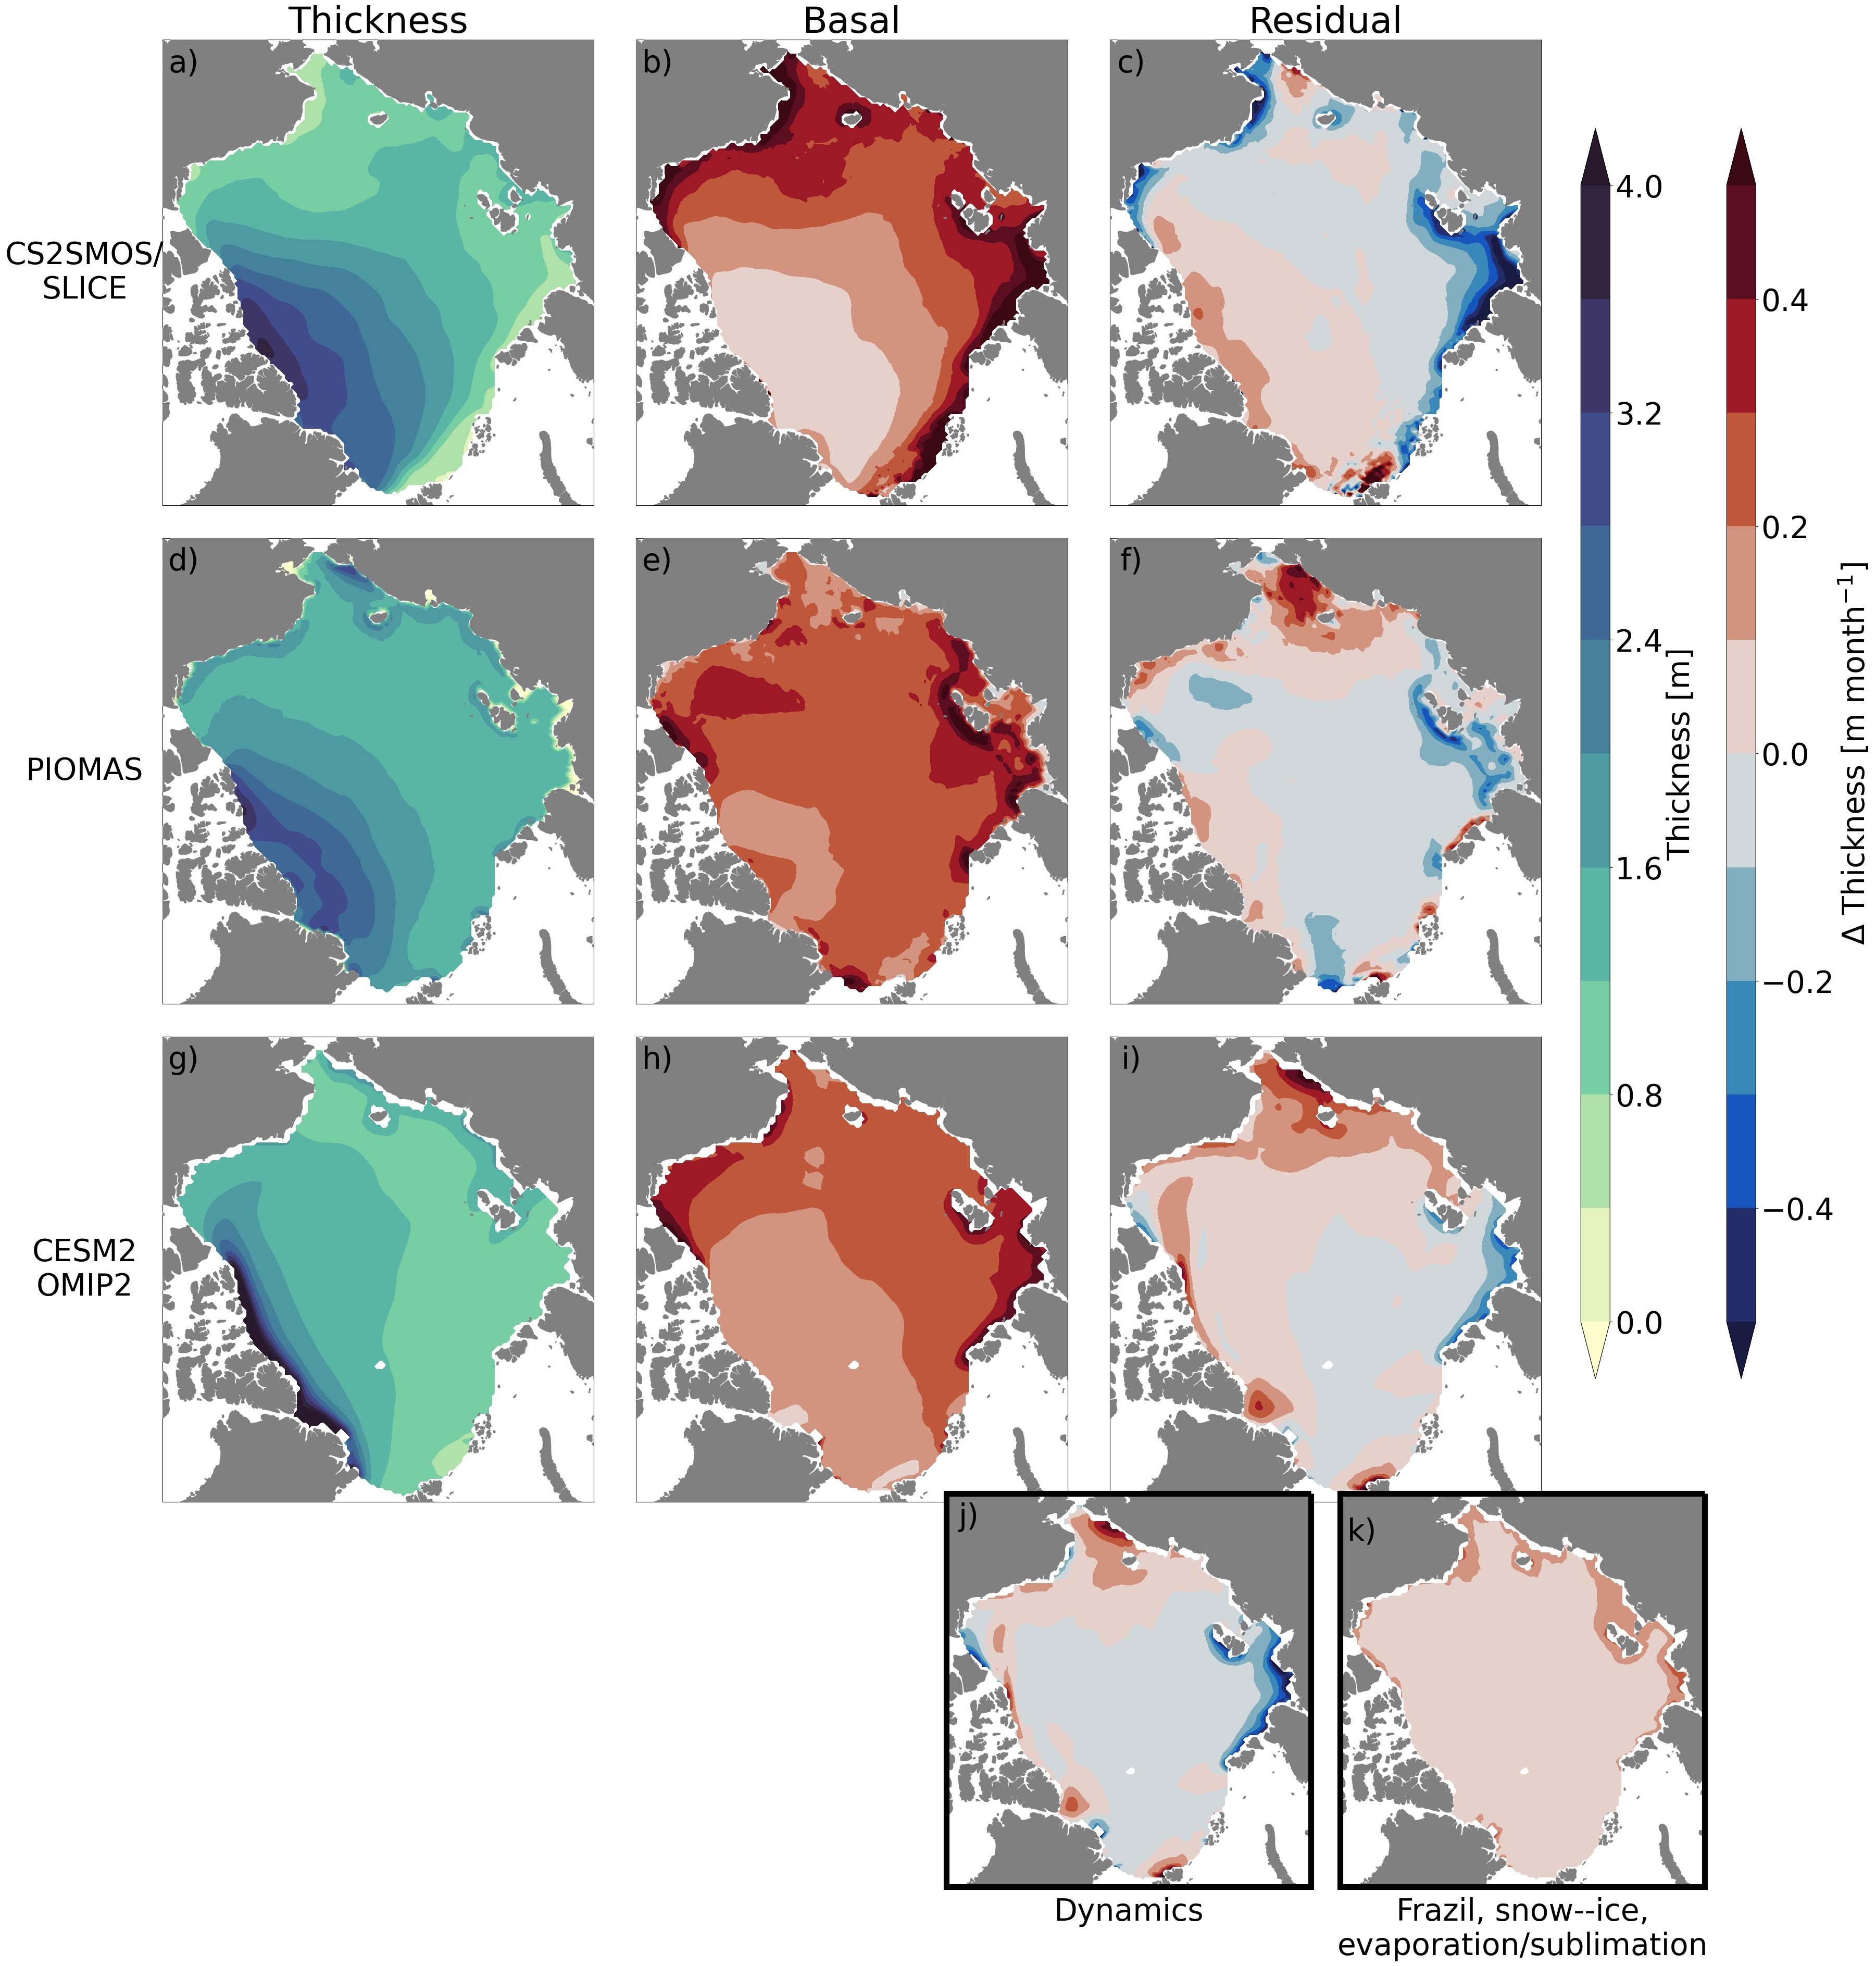

In [9]:
# Figure 1

plt.rcParams['font.size']=42

proj=ccrs.Stereographic(central_longitude=0, central_latitude=90)

f, ax = plt.subplots(3, 3, subplot_kw={'projection': proj},gridspec_kw={'width_ratios': [1, 1, 1]})
ax=ax.ravel()
f.set_figheight(30)
f.set_figwidth(28)

for i in range(len(ax)):
    ax[i].set_extent([-1800000, 1750000, -1150000, 2700000], crs=ccrs.epsg(6931))
    ax[i].add_feature(cy.feature.LAND, zorder=100, color='grey', edgecolor='k')
    ax[i].text(0.05, 0.95, string.ascii_lowercase[i]+")", zorder=101, transform=ax[i].transAxes, va='center', ha='center')
    
ax[0].set_title('Thickness')
c=ax[0].contourf(alltime.y, alltime.x, alltime.mean('time').where(alltime.rmask<6).cs2.where(sic>0).values,levels=np.linspace(0,4,11), extend='both',vmin=0, vmax=4,cmap=cmo.deep,transform=ccrs.epsg(6931))

cbar_ax = f.add_axes([1, 0.1, 0.02, 0.8])
cb=f.colorbar(c, cax=cbar_ax, label='Thickness [m]')

ax[1].set_title('Basal')
c=ax[1].contourf(alltime.y, alltime.x, 30.2*alltime.thm.mean('time')/7,levels=np.linspace(-0.5,0.5,11), extend='both',vmin=-0.5, vmax=0.5,cmap=cmo.balance,transform=ccrs.epsg(6931))

ax[2].set_title('Residual')
c=ax[2].contourf(alltime.y, alltime.x, 30.2*alltime.dyn.mean('time')/7,levels=np.linspace(-0.5,0.5,11), extend='both',vmin=-0.5, vmax=0.5,cmap=cmo.balance,transform=ccrs.epsg(6931))

cbar_ax = f.add_axes([1.1, 0.1, 0.02, 0.8])
cb=f.colorbar(c, cax=cbar_ax, label='$\Delta$ Thickness [m month$^{-1}$]')

c=ax[3].contourf(alltime.y, alltime.x, ph,levels=np.linspace(0,4,11), extend='both',vmin=0, vmax=4,cmap=cmo.deep,transform=ccrs.epsg(6931))

c=ax[4].contourf(alltime.y, alltime.x, pt,levels=np.linspace(-0.5,0.5,11), extend='both',vmin=-0.5, vmax=0.5,cmap=cmo.balance,transform=ccrs.epsg(6931))

c=ax[5].contourf(alltime.y, alltime.x, pd,levels=np.linspace(-0.5,0.5,11), extend='both',vmin=-0.5, vmax=0.5,cmap=cmo.balance,transform=ccrs.epsg(6931))

c=ax[6].contourf(alltime.y, alltime.x, oh,levels=np.linspace(0,4,11), extend='both',vmin=0, vmax=4,cmap=cmo.deep,transform=ccrs.epsg(6931))

c=ax[7].contourf(alltime.y, alltime.x, otbot,levels=np.linspace(-0.5,0.5,11), extend='both',vmin=-0.5, vmax=0.5,cmap=cmo.balance,transform=ccrs.epsg(6931))

c=ax[8].contourf(alltime.y, alltime.x, od+owat+oi+oie,levels=np.linspace(-0.5,0.5,11), extend='both',vmin=-0.5, vmax=0.5,cmap=cmo.balance,transform=ccrs.epsg(6931))

odyn_ax = f.add_axes([0.565, -0.24, 0.25, 0.25*1.125], projection=proj)
odyn_ax.set_extent([-1800000, 1750000, -1150000, 2700000], crs=ccrs.epsg(6931))
odyn_ax.add_feature(cy.feature.LAND, zorder=1, color='grey', edgecolor='k')
odyn_ax.text(0.06, 0.94, string.ascii_lowercase[i+1]+")", zorder=101, transform=odyn_ax.transAxes, va='center', ha='center')
[i.set_linewidth(8) for i in odyn_ax.spines.values()]
c=odyn_ax.contourf(alltime.y, alltime.x, od, levels=np.linspace(-0.5,0.5,11), extend='both',vmin=-0.5, vmax=0.5,cmap=cmo.balance,transform=ccrs.epsg(6931))
odyn_ax.text(0.5, -0.025, "Dynamics", transform=odyn_ax.transAxes, va='top', ha='center')

othm_ax = f.add_axes([0.835, -0.24, 0.25, 0.25*1.125], projection=proj)
othm_ax.set_extent([-1800000, 1750000, -1150000, 2700000], crs=ccrs.epsg(6931))
othm_ax.add_feature(cy.feature.LAND, zorder=1, color='grey', edgecolor='k')
othm_ax.text(0.06, 0.94, string.ascii_lowercase[i+2]+")", zorder=101, transform=othm_ax.transAxes, va='top', ha='center')
[i.set_linewidth(8) for i in othm_ax.spines.values()]
c=othm_ax.contourf(alltime.y, alltime.x, owat+oi+oie, levels=np.linspace(-0.5,0.5,11), extend='both',vmin=-0.5, vmax=0.5,cmap=cmo.balance,transform=ccrs.epsg(6931))
othm_ax.text(0.5, -0.025, "Frazil, snow--ice,\nevaporation/sublimation", transform=othm_ax.transAxes, va='top', ha='center')

f.tight_layout()

ax[0].text(-0.18, 0.5, "CS2SMOS/\nSLICE", transform=ax[0].transAxes, va='center', ha='center')
ax[3].text(-0.18, 0.5, "PIOMAS", transform=ax[3].transAxes, va='center', ha='center')
ax[6].text(-0.18, 0.5, "CESM2\nOMIP2", transform=ax[6].transAxes, va='center', ha='center')

plt.savefig(outfp + 'mod_all.png', bbox_inches="tight")

/tmp/ipykernel_2781833/1501539850.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


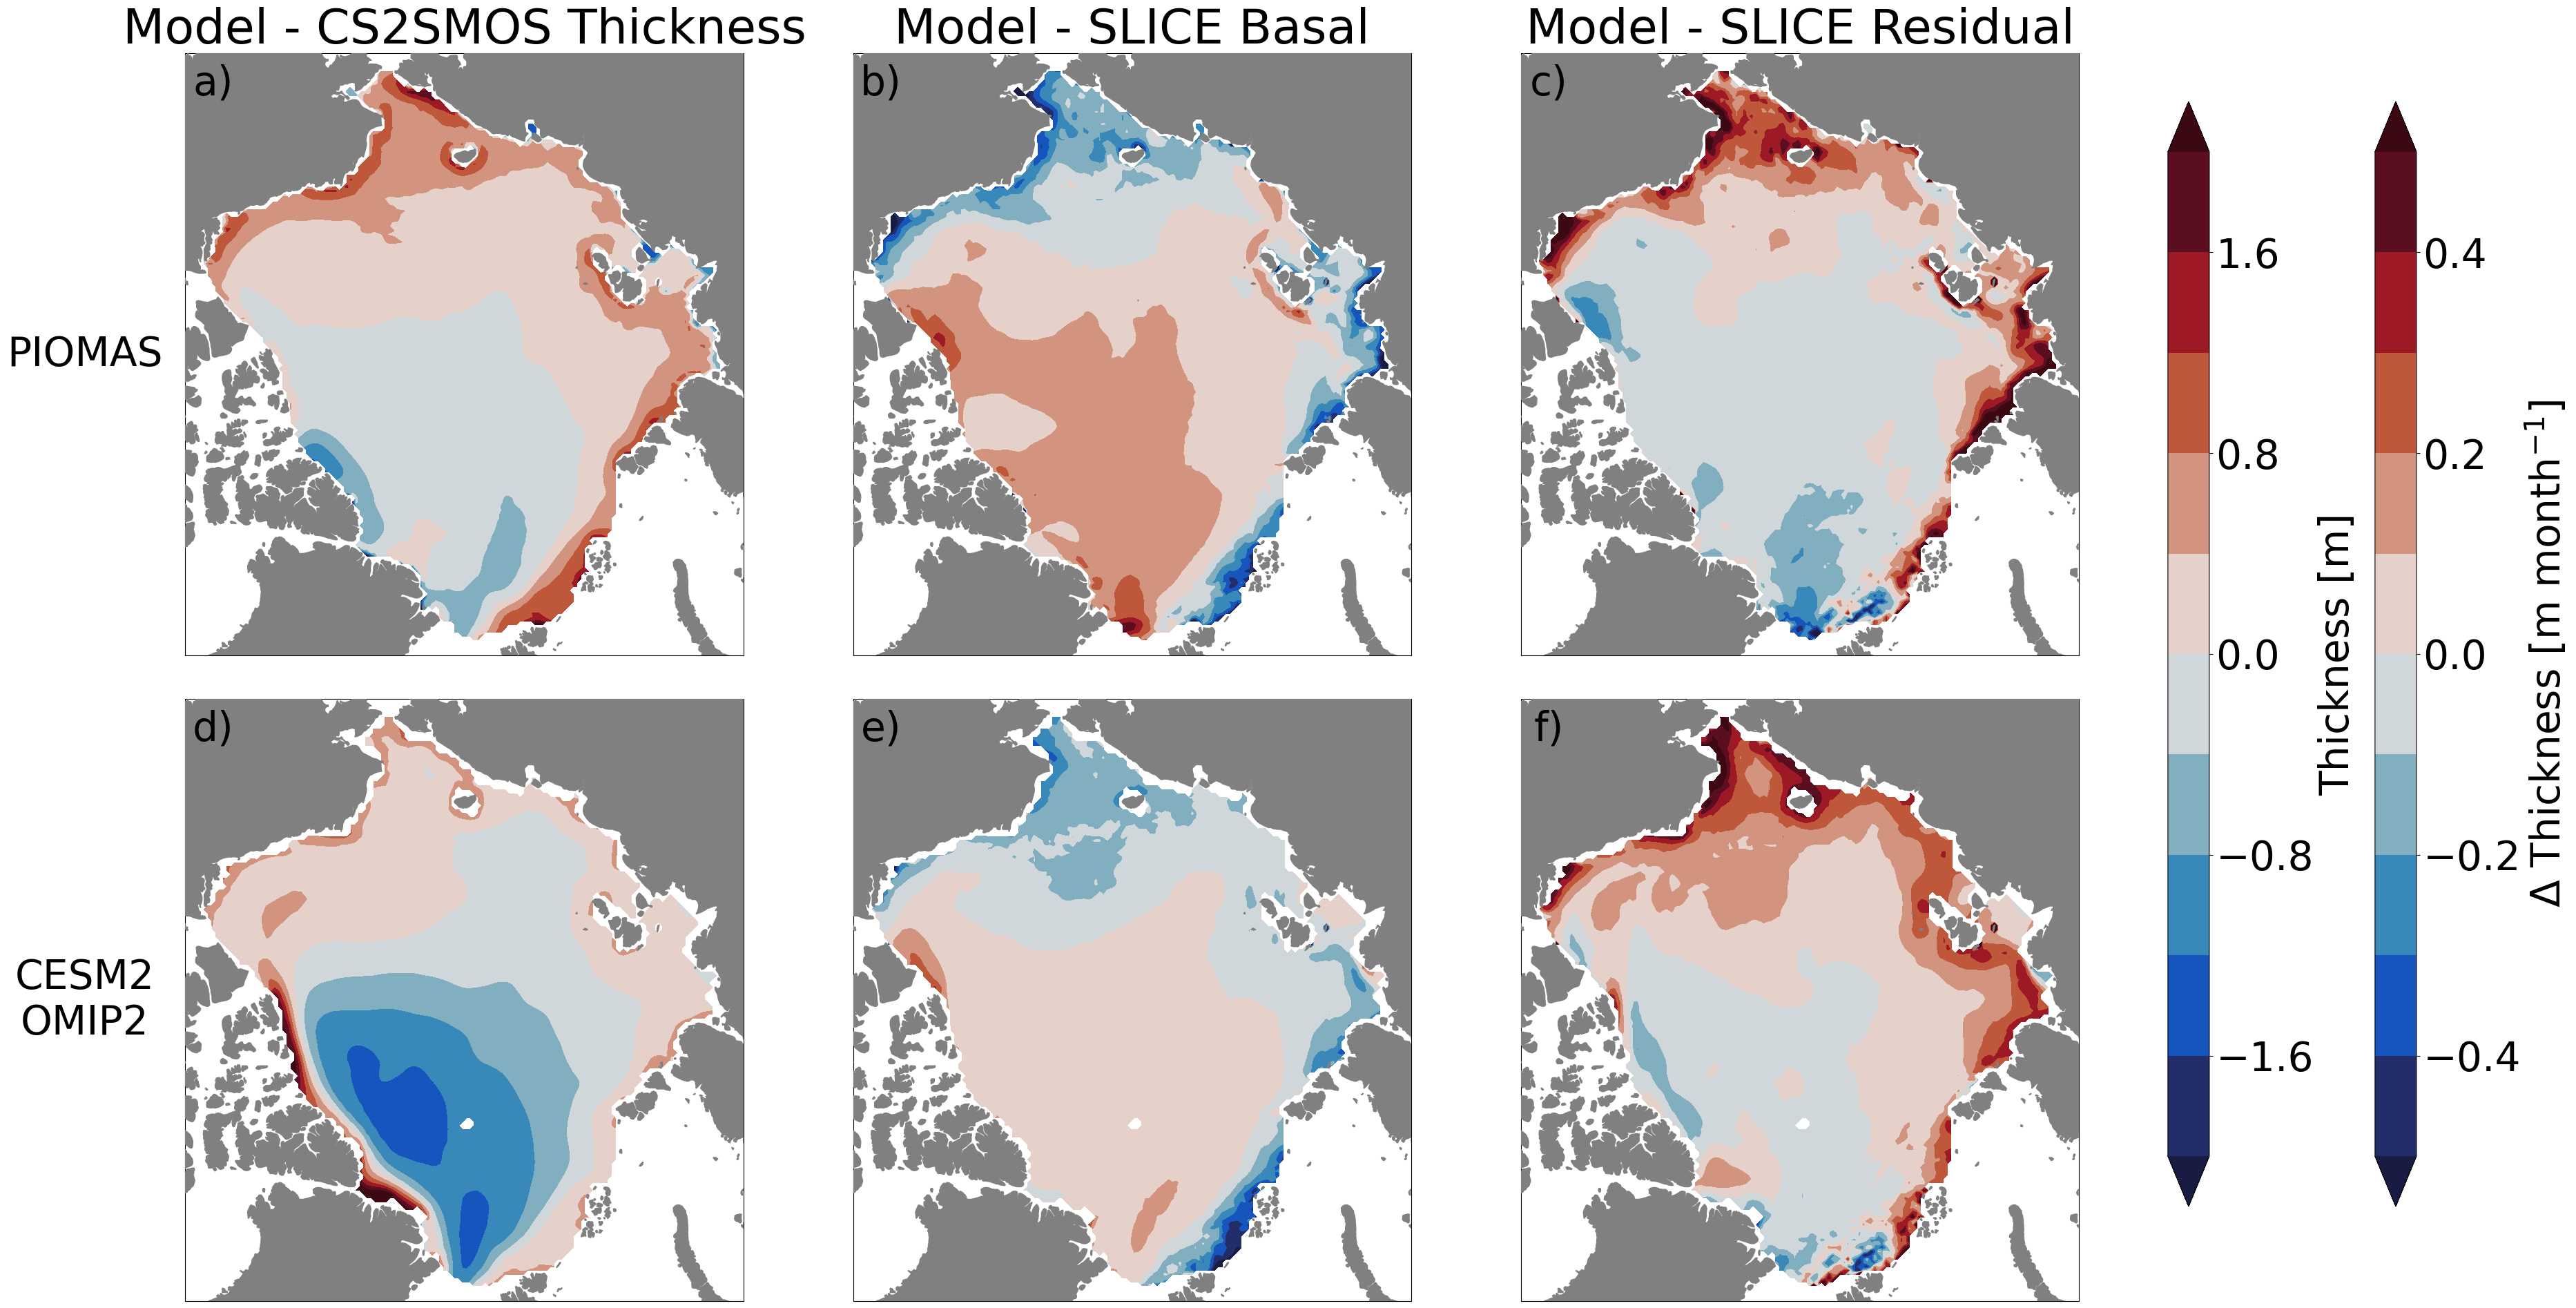

In [10]:
# Figure 2

plt.rcParams['font.size']=42

proj=ccrs.Stereographic(central_longitude=0, central_latitude=90)

f, ax = plt.subplots(2, 3, subplot_kw={'projection': proj},gridspec_kw={'width_ratios': [1, 1, 1]})
ax=ax.ravel()
f.set_figheight(20)
f.set_figwidth(30)

for i in range(len(ax)):
    ax[i].set_extent([-1800000, 1750000, -1150000, 2700000], crs=ccrs.epsg(6931))
    ax[i].add_feature(cy.feature.LAND, zorder=100, color='grey', edgecolor='k')
    ax[i].text(0.05, 0.95, string.ascii_lowercase[i]+")", zorder=101, transform=ax[i].transAxes, va='center', ha='center')
    
ax[0].set_title('Model - CS2SMOS Thickness')
c=ax[0].contourf(alltime.y, alltime.x, ph-alltime.mean('time').cs2.values,levels=np.linspace(-2,2,11), extend='both',vmin=-2, vmax=2,cmap=cmo.balance,transform=ccrs.epsg(6931))

cbar_ax = f.add_axes([1, 0.1, 0.02, 0.8])
cb=f.colorbar(c, cax=cbar_ax, label='Thickness [m]')

ax[1].set_title('Model - SLICE Basal')
c=ax[1].contourf(alltime.y, alltime.x, pt-30.2*alltime.thm.mean('time')/7,levels=np.linspace(-0.5,0.5,11), extend='both',vmin=-0.5, vmax=0.5,cmap=cmo.balance,transform=ccrs.epsg(6931))

ax[2].set_title('Model - SLICE Residual')
c=ax[2].contourf(alltime.y, alltime.x, pd-30.2*alltime.dyn.mean('time')/7,levels=np.linspace(-0.5,0.5,11), extend='both',vmin=-0.5, vmax=0.5,cmap=cmo.balance,transform=ccrs.epsg(6931))

cbar_ax = f.add_axes([1.1, 0.1, 0.02, 0.8])
cb=f.colorbar(c, cax=cbar_ax, label='$\Delta$ Thickness [m month$^{-1}$]')

c=ax[3].contourf(alltime.y, alltime.x, oh-alltime.mean('time').cs2.where(sic>0).values,levels=np.linspace(-2,2,11), extend='both',vmin=-2, vmax=2,cmap=cmo.balance,transform=ccrs.epsg(6931))

c=ax[4].contourf(alltime.y, alltime.x,  otbot-30.2*alltime.thm.mean('time').where(sic>0)/7,levels=np.linspace(-0.5,0.5,11), extend='both',vmin=-0.5, vmax=0.5,cmap=cmo.balance,transform=ccrs.epsg(6931))

c=ax[5].contourf(alltime.y, alltime.x, od+owat+oi+oie-30.2*alltime.dyn.mean('time').where(sic>0)/7,levels=np.linspace(-0.5,0.5,11), extend='both',vmin=-0.5, vmax=0.5,cmap=cmo.balance,transform=ccrs.epsg(6931))

f.tight_layout()

ax[0].text(-0.18, 0.5, "PIOMAS", transform=ax[0].transAxes, va='center', ha='center')
ax[3].text(-0.18, 0.5, "CESM2\nOMIP2", transform=ax[3].transAxes, va='center', ha='center')

plt.savefig(outfp + 'mod_comp.png', bbox_inches="tight")

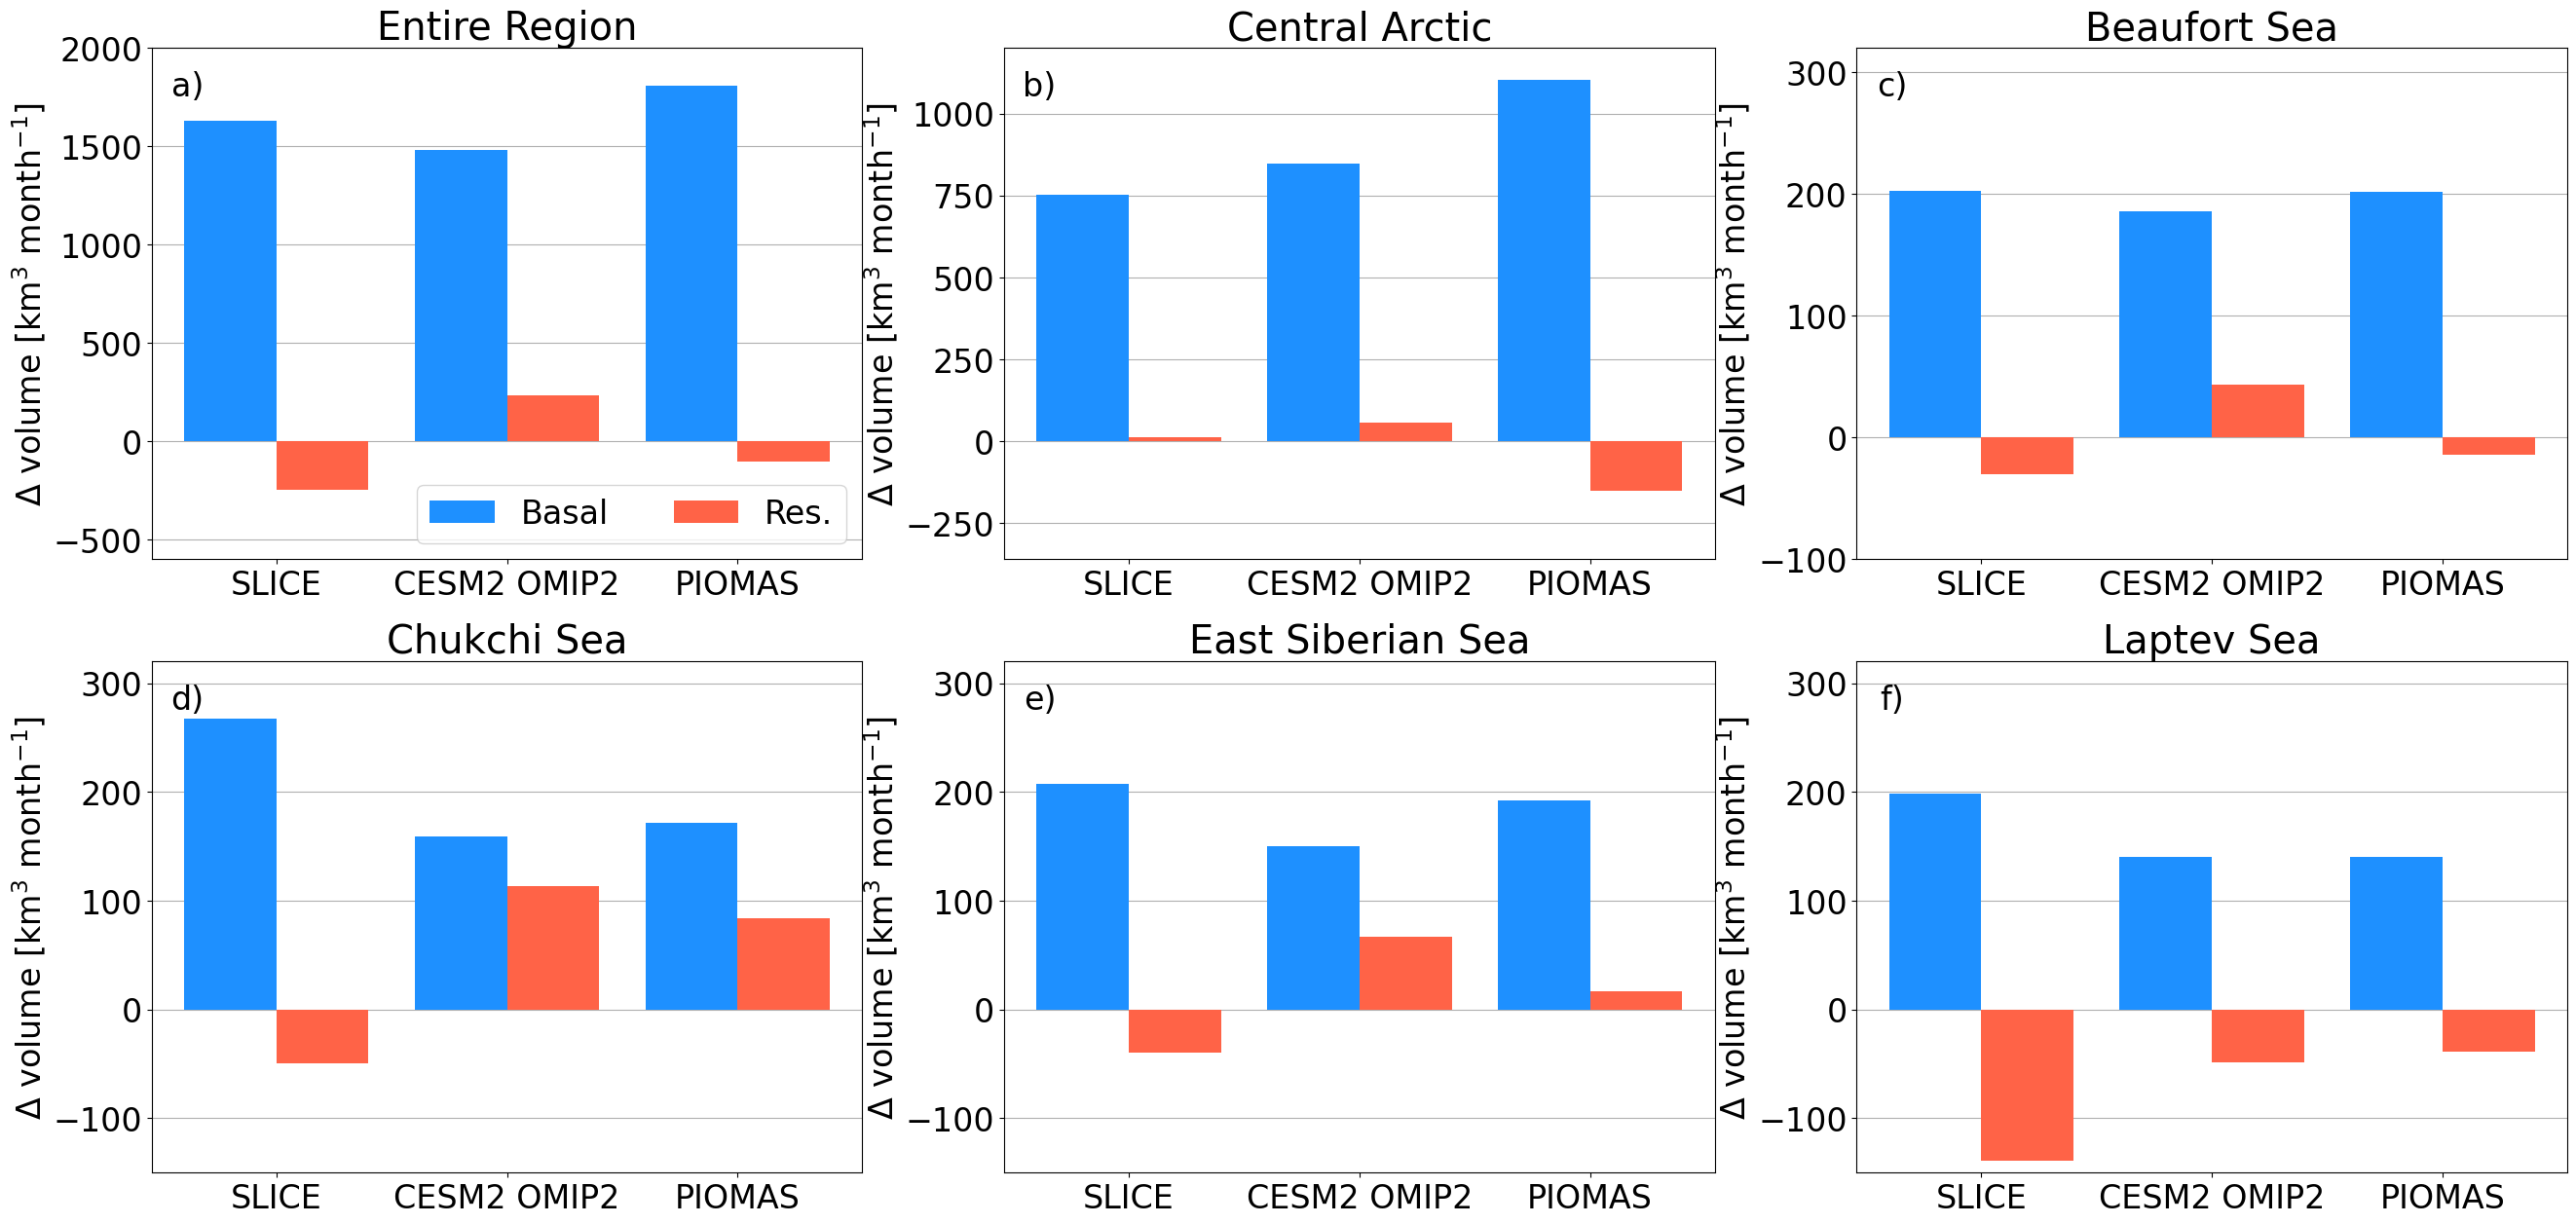

In [11]:
# Figure 3

plt.rcParams['font.size']=24

f, ax = plt.subplots(2, 3)
ax=ax.ravel()
f.set_figheight(15)
f.set_figwidth(32)

rmask_labels=['Entire Region','Central Arctic','Beaufort Sea','Chukchi Sea','East Siberian Sea','Laptev Sea','Kara Sea','Barents Sea','East Greenland Sea','Baffin Bay','Canadian Archipelago']

ylim=[(-600,2000),(-360,1200),(-100,320),(-150,320),(-150,320),(-150,320)]

for i in [1,2,3,4,5]:
    ax[i].text(0.05, 0.925, string.ascii_lowercase[i]+")", zorder=101, transform=ax[i].transAxes, va='center', ha='center')
    
    monthly=30.2*25*25/1000*alltime.where(alltime.rmask==i).mean('time').sum(('y','x'))/7
                                
    ax[i].set_axisbelow(True)
    
    ax[i].bar(1, monthly.thm, color='dodgerblue')
    ax[i].bar(3, 25*25/1000*otbot.where(alltime.rmask==i).sum(('y','x')), color='dodgerblue')
    ax[i].bar(5, 25*25/1000*pt.where(alltime.rmask==i).sum(('y','x')), color='dodgerblue')
    
    ax[i].bar(1.8, monthly.dyn, color='tomato')
    ax[i].bar(3.8, 25*25/1000*(od.where(alltime.rmask==i).sum(('y','x'))+owat.where(alltime.rmask==i).sum(('y','x'))+oi.where(alltime.rmask==i).sum(('y','x'))+oie.where(alltime.rmask==i).sum(('y','x'))), color='tomato')
    ax[i].bar(5.8, 25*25/1000*pd.where(alltime.rmask==i).sum(('y','x')), color='tomato')

    ax[i].set_title(rmask_labels[i])
    ax[i].set_xticks([1.4,3.4,5.4],labels=['SLICE','CESM2 OMIP2','PIOMAS'])
    ax[i].set_ylim(ylim[i])
    ax[i].grid(axis='y')
    ax[i].set_ylabel('$\Delta$ volume [km$^{3}$ month$^{-1}$]')

monthly=30.2*25*25/1000*alltime.mean('time').sum(('y','x'))/7

ax[0].text(0.05, 0.925, string.ascii_lowercase[0]+")", zorder=101, transform=ax[0].transAxes, va='center', ha='center')

ax[0].set_axisbelow(True)

ax[0].bar(1, monthly.thm, color='dodgerblue',label='Basal')
ax[0].bar(3, 25*25/1000*otbot.sum(('y','x')), color='dodgerblue')
ax[0].bar(5, 25*25/1000*pt.sum(('y','x')), color='dodgerblue')

ax[0].bar(1.8, monthly.dyn, color='tomato',label='Res.')
ax[0].bar(3.8, 25*25/1000*(od.sum(('y','x'))+owat.sum(('y','x'))+oi.sum(('y','x'))+oie.sum(('y','x'))), color='tomato')
ax[0].bar(5.8, 25*25/1000*pd.sum(('y','x')), color='tomato')

ax[0].set_title(rmask_labels[0])
ax[0].set_xticks([1.4,3.4,5.4],labels=['SLICE','CESM2 OMIP2','PIOMAS'])
ax[0].set_ylim(ylim[0])
ax[0].legend(ncol=2)
ax[0].grid(axis='y')
ax[0].set_ylabel('$\Delta$ volume [km$^{3}$ month$^{-1}$]')

plt.savefig(outfp + 'mod_bar.png', bbox_inches="tight")


/home/janheuser/.conda/envs/modcomp/lib/python3.10/site-packages/xarray/conventions.py:523: SerializationWarning: variable 'siconc' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/janheuser/.conda/envs/modcomp/lib/python3.10/site-packages/xarray/conventions.py:523: SerializationWarning: variable 'sithick' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/tmp/ipykernel_2781833/498068600.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


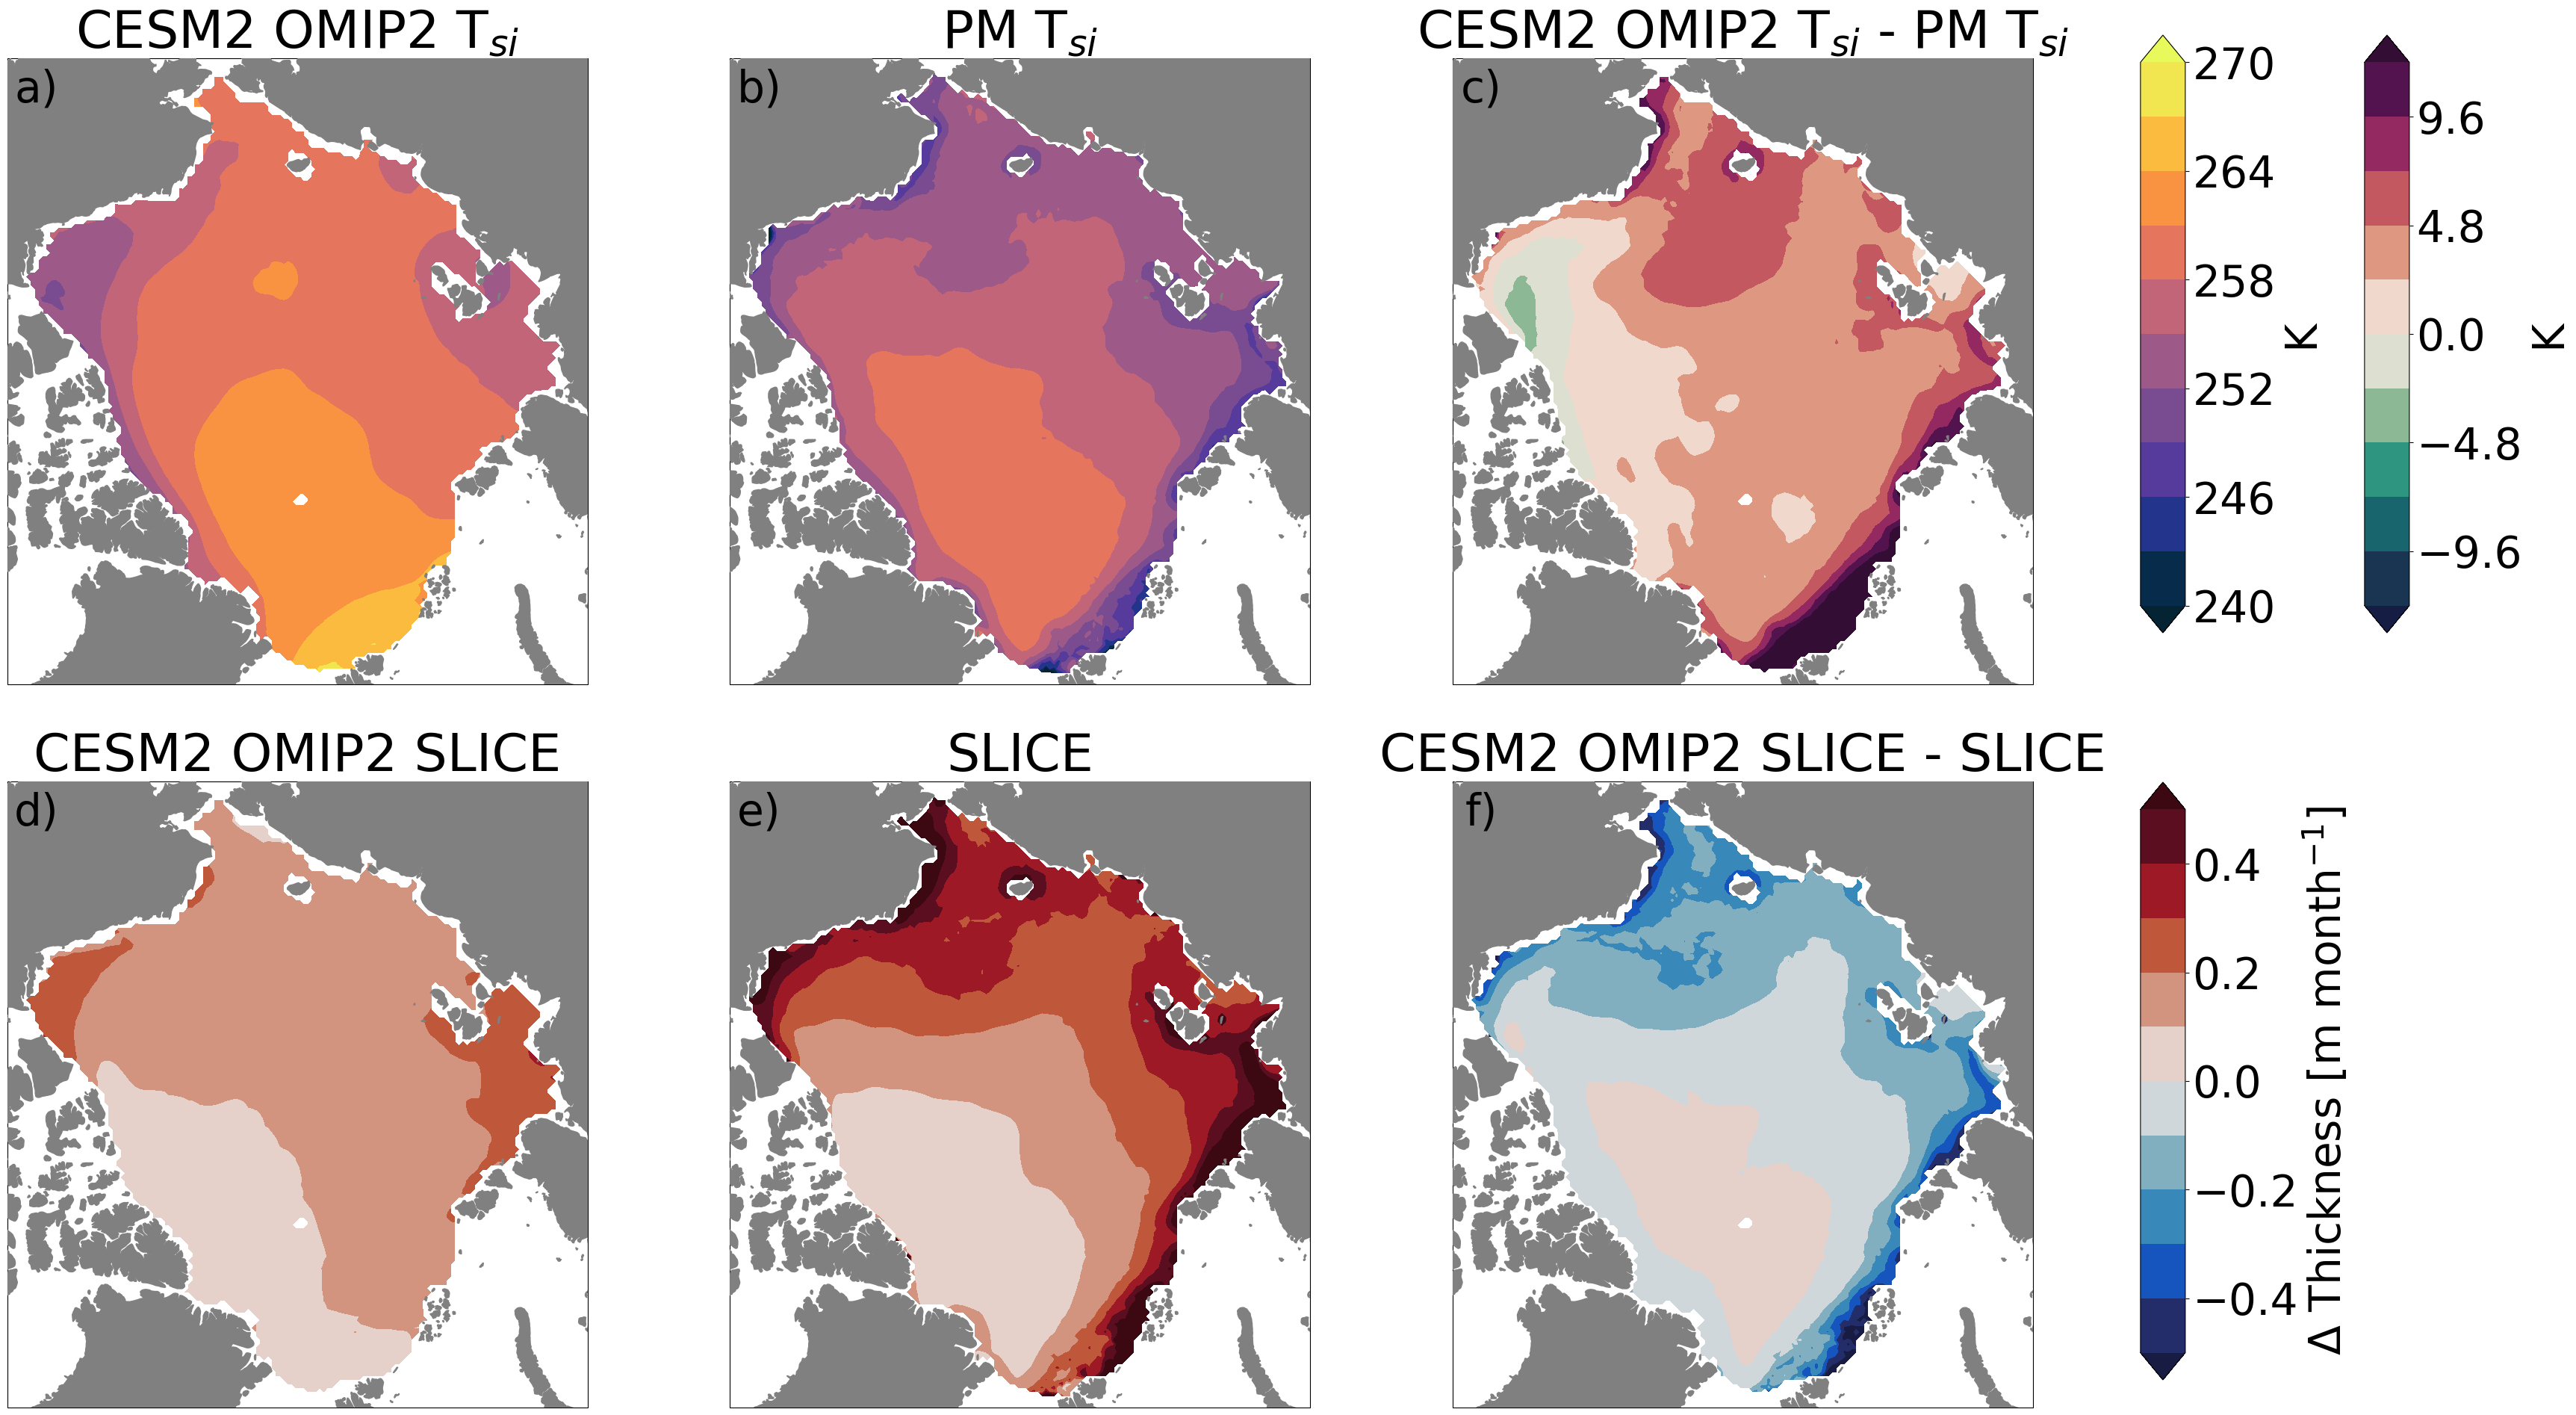

In [12]:
# Figure 4

plt.rcParams['font.size']=42

oam=xr.open_mfdataset(omipdir + 'siconc_SImon_CESM2_omip2_r1i1p1f1_gn_030601-036612.nc').siconc.isel(time=np.concatenate([np.arange(-97,-93,dtype=int),np.arange(-74,-0,dtype=int)]))
ositm=xr.open_mfdataset(omipdir + 'g.e21.GOMIPECOIAF_JRA.TL319_g17.CMIP6-omip2.001.cice.h.sitempsnic.030601-036612.nc').sitempsnic.isel(time=np.concatenate([np.arange(-97,-93,dtype=int),np.arange(-74,-0,dtype=int)]))
ositm['time']=oam.time
ohm=xr.open_mfdataset(omipdir + 'sithick_SImon_CESM2_omip2_r1i1p1f1_gn_030601-036612.nc').sithick.isel(time=np.concatenate([np.arange(-97,-93,dtype=int),np.arange(-74,-0,dtype=int)]))

x, y = transformer.transform(oam.lat.where((oam.lat < 361) & (oam.lon < 361)).values.ravel(), 
                             oam.lon.where((oam.lat < 361) & (oam.lon < 361)).values.ravel())

osteflaw = 30.2*(stefpred(ohm.where(oam>95), ositm.where(oam>95), 2, 86400)-ohm.where(oam>95))
osteflaw=xr.DataArray(griddata((y, x), osteflaw.mean('time').values.ravel(), (alltime.y.values[:,None], alltime.x.values[None,:]), 
             method='linear'), coords=[alltime.y.values, alltime.x.values], dims=["y", "x"])

f, ax = plt.subplots(2, 3, subplot_kw={'projection': proj})
ax=ax.ravel()
f.set_figheight(20)
f.set_figwidth(30)

for i in range(len(ax)):
    ax[i].set_extent([-1800000, 1750000, -1150000, 2700000], crs=ccrs.epsg(6931))
    ax[i].add_feature(cy.feature.LAND, zorder=100, color='grey', edgecolor='k')
    ax[i].text(0.05, 0.95, string.ascii_lowercase[i]+")", zorder=101, transform=ax[i].transAxes, va='center', ha='center')

c=ax[0].contourf(osit.y, osit.x, osit,levels=np.linspace(240,270,11), extend='both', vmin=240, vmax=270,cmap=cmo.thermal,transform=ccrs.epsg(6931))
ax[0].set_title("CESM2 OMIP2 T$_{si}$")
c=ax[1].contourf(osit.y, osit.x, alltime.tsi.mean('time'),levels=np.linspace(240,270,11), extend='both',vmin=240, vmax=270,cmap=cmo.thermal,transform=ccrs.epsg(6931))
ax[1].set_title("PM T$_{si}$")
cbar_ax = f.add_axes([1, 0.55, 0.02, 0.4])
plt.colorbar(c, cax=cbar_ax, label='K')
c=ax[2].contourf(osit.y, osit.x, osit-alltime.tsi.mean('time'),levels=np.linspace(-12,12,11), extend='both',vmin=-12, vmax=12,cmap=cmo.curl,transform=ccrs.epsg(6931))
ax[2].set_title("CESM2 OMIP2 T$_{si}$ - PM T$_{si}$")
cbar_ax = f.add_axes([1.1, 0.55, 0.02, 0.4])
plt.colorbar(c, cax=cbar_ax, label='K')
c=ax[3].contourf(osit.y, osit.x, osteflaw.where(alltime.rmask<6).where(sic>0), levels=np.linspace(-0.5,0.5,11), extend='both', vmin=-0.5, vmax=0.5, cmap=cmo.balance, transform=ccrs.epsg(6931))
ax[3].set_title("CESM2 OMIP2 SLICE")
c=ax[4].contourf(osit.y, osit.x, 30.2*alltime.thm.mean('time')/7,levels=np.linspace(-0.5,0.5,11), extend='both', vmin=-0.5, vmax=0.5, cmap=cmo.balance, transform=ccrs.epsg(6931))
ax[4].set_title("SLICE")
c=ax[5].contourf(osit.y, osit.x, osteflaw.where(alltime.rmask<6).where(sic>0)-30.2*alltime.thm.mean('time')/7,levels=np.linspace(-0.5,0.5,11), extend='both', vmin=-0.5, vmax=0.5, cmap=cmo.balance, transform=ccrs.epsg(6931))
ax[5].set_title("CESM2 OMIP2 SLICE - SLICE")
cbar_ax = f.add_axes([1, 0.05, 0.02, 0.4])
plt.colorbar(c, cax=cbar_ax, label='$\Delta$ Thickness [m month$^{-1}$]')

f.tight_layout()

plt.savefig(outfp + 'mod_tsi.png', bbox_inches="tight")